In [11]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import scipy.stats as stats
import time
import pickle

# Import Ngl with pyn_env active 
import Ngl

import warnings
warnings.filterwarnings('ignore')


In [12]:

# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds



In [13]:
def interpolateToPressure_v2(DS, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DS.P0.values[0]/100        # mb

    # Pull out hya/hyb profiles 
    hyam = DS.hyam.values[0,:]
    hybm = DS.hybm.values[0,:]
    hyai = DS.hyai.values[0,:]
    hybi = DS.hybi.values[0,:]

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

### Read in data

In [14]:
start_time = time.time()

saveDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/ProcessedFiles/'

realSfc_allCases          = pickle.load( open( saveDir+"realSfc_allCases_withInterp.p", "rb" ) )

HMGclmDS_localReal        = pickle.load( open( saveDir+"HMGclmDS_localReal.p", "rb" ) )
HTGclmDS_localReal        = pickle.load( open( saveDir+"HTGclmDS_localReal.p", "rb" ) )
HTGclmDS_localReal10      = pickle.load( open( saveDir+"HTGclmDS_localReal10.p", "rb" ) )

HMGclmDS_localRealPatch   = pickle.load( open( saveDir+"HMGclmDS_localRealPatch.p", "rb" ) )
HTGclmDS_localRealPatch   = pickle.load( open( saveDir+"HTGclmDS_localRealPatch.p", "rb" ) )
HTGclmDS_localRealPatch10 = pickle.load( open( saveDir+"HTGclmDS_localRealPatch10.p", "rb" ) )

print('Loaded all the real_sfc pickle files')

print('Total elapsed time (sec): ', time.time()-start_time)


Loaded all the real_sfc pickle files
Total elapsed time (sec):  20.5239520072937


**If want set of days:**

In [15]:
'''
Find all the times in the full array (20m dt) that line up with the day classifications above. 
'''
def getTimes_basedOnDates(fullDS, matchDates):
    iTimes = []
    
    for iTime in range(len(matchDates.year_month_day.values)):
        iKeepTimes = np.where((fullDS['time.year'] ==matchDates.year_month_day_level_0.values[iTime]) &
                              (fullDS['time.month']==matchDates.year_month_day_level_1.values[iTime]) & 
                              (fullDS['time.day']  ==matchDates.year_month_day_level_2.values[iTime]))[0]    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_dayClass = fullDS.isel(time=iTimes)
    
    return(DS_dayClass)


In [33]:
## Use files automatically created with other script
filePath = '/Users/mdfowler/Documents/Analysis/CLASP/SensitiveDaysToHTG_PBLH_HTGonlyDefined.csv'
# filePath = '/Users/mdfowler/Documents/Analysis/CLASP/SensitiveDaysToHTG_PBLH_HTG10onlyDefined.csv'

cssDF    = pd.read_csv(filePath, header=0, usecols=[1,2], names=['pos', 'neg'])

# Get dates for LWP positive days:
cssDF.pos = pd.to_datetime(cssDF.pos, format="%Y-%m-%d")
cssDF.neg = pd.to_datetime(cssDF.neg, format="%Y-%m-%d")

# Turn into an xarray dataset (more familiar with that)
cssDS   = cssDF.to_xarray()



## Add in other budget terms

In [7]:
# This set uses theta, not theta_v; and adds outputs of rt'thv' and tau
dataDir      = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc_buoyancyTau_useTheta/'
caseName_HMG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_plusBuoyancyTau_useTheta_'
caseName_HTG = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc_plusBuoyancyTau_useTheta_'

# dataDirHTG10   = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/FinalOption/betterFinidat4_MoreMomentsNoReorder/5minCoupling/realSfc_HTGtimes10/'
# caseName_HTG10 = 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_betterFinidat4_MoreMomentsNoReorder_5mDt_realSfc10htg_plusBuoyancyTauThetavs_useTheta_'

yearStrings  = np.asarray(['2015','2016','2017','2018'])


**wp2 terms**

In [17]:
## Add other vars to the list

fileCount=0
for iYr in range(len(yearStrings)): 

    fileStart_atm_HMG   = dataDir+caseName_HMG+yearStrings[iYr]+'jja.cam.h0.'
    fileStart_atm_HTG   = dataDir+caseName_HTG+yearStrings[iYr]+'jja.cam.h0.'
#     fileStart_atm_HTG10 = dataDirHTG10+caseName_HTG10+yearStrings[iYr]+'jja.cam.h0.'

    fileName_atm_HMG   = fileStart_atm_HMG+'wp2BudgetTerms.nc'
    fileName_atm_HTG   = fileStart_atm_HTG+'wp2BudgetTerms.nc'
#     fileName_atm_HTG10 = fileStart_atm_HTG10+'wp2BudgetTerms.nc'
    
        
    with xr.open_dataset(fileName_atm_HMG, decode_times=False) as HMG_camDS:
        HMG_camDS = cesm_correct_time(HMG_camDS)
        HMG_camDS['time'] = HMG_camDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(fileName_atm_HTG, decode_times=False) as HTG_camDS:
        HTG_camDS = cesm_correct_time(HTG_camDS)
        HTG_camDS['time'] = HTG_camDS.indexes['time'].to_datetimeindex()  
#     with xr.open_dataset(fileName_atm_HTG10, decode_times=False) as HTG10_camDS:
#         HTG10_camDS = cesm_correct_time(HTG10_camDS)
#         HTG10_camDS['time'] = HTG10_camDS.indexes['time'].to_datetimeindex() 

            
    # Discard first two days 
    iTimeStart   = np.where(HMG_camDS.time.values >= (HMG_camDS.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMG_camDS.time.values))

#     HTG10_camDS  = HTG10_camDS.isel(time=timeArr)
    HTG_camDS    = HTG_camDS.isel(time=timeArr)
    HMG_camDS    = HMG_camDS.isel(time=timeArr)


    if fileCount==0:
#         HTG10camDS_realSfcExtra = HTG10_camDS
        HTGcamDS_realSfcExtra   = HTG_camDS
        HMGcamDS_realSfcExtra   = HMG_camDS  
    else: 
#         HTG10camDS_realSfcExtra = xr.concat([HTG10camDS_realSfcExtra,HTG10_camDS], dim='time')
        HTGcamDS_realSfcExtra   = xr.concat([HTGcamDS_realSfcExtra,HTG_camDS], dim='time')
        HMGcamDS_realSfcExtra   = xr.concat([HMGcamDS_realSfcExtra,HMG_camDS], dim='time')
            
    fileCount = fileCount+1
    print('Done with file %i of %i '% (fileCount,len(yearStrings)))


Done with file 1 of 4 
Done with file 2 of 4 
Done with file 3 of 4 
Done with file 4 of 4 


In [18]:
## Convert to local times...
# HTG10camDS_realSfcExtra_local = HTG10camDS_realSfcExtra.copy(deep=True)
HTGcamDS_realSfcExtra_local   = HTGcamDS_realSfcExtra.copy(deep=True)
HMGcamDS_realSfcExtra_local   = HMGcamDS_realSfcExtra.copy(deep=True)

# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGcamDS_realSfcExtra_local['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
# HTG10camDS_realSfcExtra_local = HTG10camDS_realSfcExtra_local.assign_coords({"time": localTimes})
HTGcamDS_realSfcExtra_local   = HTGcamDS_realSfcExtra_local.assign_coords({"time": localTimes})
HMGcamDS_realSfcExtra_local   = HMGcamDS_realSfcExtra_local.assign_coords({"time": localTimes})



In [19]:
# Merge into larger dataset
# HTG10camDS_localReal = xr.merge([realSfc_allCases.isel(case=2),   HTG10camDS_realSfcExtra_local])
HTGcamDS_localReal   = xr.merge([realSfc_allCases.isel(case=1),   HTGcamDS_realSfcExtra_local])
HMGcamDS_localReal   = xr.merge([realSfc_allCases.isel(case=0),   HMGcamDS_realSfcExtra_local])


In [20]:
# del HTG10camDS_realSfcExtra
del HTGcamDS_realSfcExtra
del HMGcamDS_realSfcExtra

# del HTG10camDS_realSfcExtra_local
del HTGcamDS_realSfcExtra_local
del HMGcamDS_realSfcExtra_local

**wpthlp terms**

In [21]:
## Add other vars to the list

fileCount=0
for iYr in range(len(yearStrings)): 

    fileStart_atm_HMG   = dataDir+caseName_HMG+yearStrings[iYr]+'jja.cam.h0.'
    fileStart_atm_HTG   = dataDir+caseName_HTG+yearStrings[iYr]+'jja.cam.h0.'
#     fileStart_atm_HTG10 = dataDirHTG10+caseName_HTG10+yearStrings[iYr]+'jja.cam.h0.'

    fileName_atm_HMG   = fileStart_atm_HMG+'wpthlpBudgetTerms.nc'
    fileName_atm_HTG   = fileStart_atm_HTG+'wpthlpBudgetTerms.nc'
#     fileName_atm_HTG10 = fileStart_atm_HTG10+'wpthlpBudgetTerms.nc'
    
        
    with xr.open_dataset(fileName_atm_HMG, decode_times=False) as HMG_camDS:
        HMG_camDS = cesm_correct_time(HMG_camDS)
        HMG_camDS['time'] = HMG_camDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(fileName_atm_HTG, decode_times=False) as HTG_camDS:
        HTG_camDS = cesm_correct_time(HTG_camDS)
        HTG_camDS['time'] = HTG_camDS.indexes['time'].to_datetimeindex()  
#     with xr.open_dataset(fileName_atm_HTG10, decode_times=False) as HTG10_camDS:
#         HTG10_camDS = cesm_correct_time(HTG10_camDS)
#         HTG10_camDS['time'] = HTG10_camDS.indexes['time'].to_datetimeindex()  

            
    # Discard first two days 
    iTimeStart   = np.where(HMG_camDS.time.values >= (HMG_camDS.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMG_camDS.time.values))

#     HTG10_camDS    = HTG10_camDS.isel(time=timeArr)
    HTG_camDS      = HTG_camDS.isel(time=timeArr)
    HMG_camDS      = HMG_camDS.isel(time=timeArr)


    if fileCount==0:
#         HTG10camDS_realSfcExtra = HTG10_camDS
        HTGcamDS_realSfcExtra   = HTG_camDS
        HMGcamDS_realSfcExtra   = HMG_camDS  
    else: 
#         HTG10camDS_realSfcExtra = xr.concat([HTG10camDS_realSfcExtra,HTG10_camDS], dim='time')
        HTGcamDS_realSfcExtra   = xr.concat([HTGcamDS_realSfcExtra,HTG_camDS], dim='time')
        HMGcamDS_realSfcExtra   = xr.concat([HMGcamDS_realSfcExtra,HMG_camDS], dim='time')
            
    fileCount = fileCount+1
    print('Done with file %i of %i '% (fileCount,len(yearStrings)))


Done with file 1 of 4 
Done with file 2 of 4 
Done with file 3 of 4 
Done with file 4 of 4 


In [22]:
## Convert to local times...
# HTG10camDS_realSfcExtra_local = HTG10camDS_realSfcExtra.copy(deep=True)
HTGcamDS_realSfcExtra_local   = HTGcamDS_realSfcExtra.copy(deep=True)
HMGcamDS_realSfcExtra_local   = HMGcamDS_realSfcExtra.copy(deep=True)

# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGcamDS_realSfcExtra_local['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
# HTG10camDS_realSfcExtra_local = HTG10camDS_realSfcExtra_local.assign_coords({"time": localTimes})
HTGcamDS_realSfcExtra_local   = HTGcamDS_realSfcExtra_local.assign_coords({"time": localTimes})
HMGcamDS_realSfcExtra_local   = HMGcamDS_realSfcExtra_local.assign_coords({"time": localTimes})


In [23]:
# Merge into larger dataset
# HTG10camDS_localReal = xr.merge([HTG10camDS_localReal, HTG10camDS_realSfcExtra_local])
HTGcamDS_localReal   = xr.merge([HTGcamDS_localReal,   HTGcamDS_realSfcExtra_local])
HMGcamDS_localReal   = xr.merge([HMGcamDS_localReal,   HMGcamDS_realSfcExtra_local])


In [24]:
# del HTG10camDS_realSfcExtra
del HTGcamDS_realSfcExtra
del HMGcamDS_realSfcExtra
# del HTG10camDS_realSfcExtra_local
del HTGcamDS_realSfcExtra_local
del HMGcamDS_realSfcExtra_local

**wprtp terms**

In [25]:
## Add other vars to the list

fileCount=0
for iYr in range(len(yearStrings)): 

    fileStart_atm_HMG   = dataDir+caseName_HMG+yearStrings[iYr]+'jja.cam.h0.'
    fileStart_atm_HTG   = dataDir+caseName_HTG+yearStrings[iYr]+'jja.cam.h0.'
#     fileStart_atm_HTG10 = dataDirHTG10+caseName_HTG10+yearStrings[iYr]+'jja.cam.h0.'

    fileName_atm_HMG   = fileStart_atm_HMG+'wprtpBudgetTerms.nc'
    fileName_atm_HTG   = fileStart_atm_HTG+'wprtpBudgetTerms.nc'
#     fileName_atm_HTG10 = fileStart_atm_HTG10+'wprtpBudgetTerms.nc'
    
        
    with xr.open_dataset(fileName_atm_HMG, decode_times=False) as HMG_camDS:
        HMG_camDS = cesm_correct_time(HMG_camDS)
        HMG_camDS['time'] = HMG_camDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(fileName_atm_HTG, decode_times=False) as HTG_camDS:
        HTG_camDS = cesm_correct_time(HTG_camDS)
        HTG_camDS['time'] = HTG_camDS.indexes['time'].to_datetimeindex()  
#     with xr.open_dataset(fileName_atm_HTG10, decode_times=False) as HTG10_camDS:
#         HTG10_camDS = cesm_correct_time(HTG10_camDS)
#         HTG10_camDS['time'] = HTG10_camDS.indexes['time'].to_datetimeindex()  

            
    # Discard first two days 
    iTimeStart   = np.where(HMG_camDS.time.values >= (HMG_camDS.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMG_camDS.time.values))

#     HTG10_camDS    = HTG10_camDS.isel(time=timeArr)
    HTG_camDS      = HTG_camDS.isel(time=timeArr)
    HMG_camDS      = HMG_camDS.isel(time=timeArr)


    if fileCount==0:
#         HTG10camDS_realSfcExtra = HTG10_camDS
        HTGcamDS_realSfcExtra   = HTG_camDS
        HMGcamDS_realSfcExtra   = HMG_camDS  
    else: 
#         HTG10camDS_realSfcExtra = xr.concat([HTG10camDS_realSfcExtra,HTG10_camDS], dim='time')
        HTGcamDS_realSfcExtra   = xr.concat([HTGcamDS_realSfcExtra,HTG_camDS], dim='time')
        HMGcamDS_realSfcExtra   = xr.concat([HMGcamDS_realSfcExtra,HMG_camDS], dim='time')
            
    fileCount = fileCount+1
    print('Done with file %i of %i '% (fileCount,len(yearStrings)))


Done with file 1 of 4 
Done with file 2 of 4 
Done with file 3 of 4 
Done with file 4 of 4 


In [26]:
## Convert to local times...
# HTG10camDS_realSfcExtra_local = HTG10camDS_realSfcExtra.copy(deep=True)
HTGcamDS_realSfcExtra_local   = HTGcamDS_realSfcExtra.copy(deep=True)
HMGcamDS_realSfcExtra_local   = HMGcamDS_realSfcExtra.copy(deep=True)

# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGcamDS_realSfcExtra_local['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
# HTG10camDS_realSfcExtra_local = HTG10camDS_realSfcExtra_local.assign_coords({"time": localTimes})
HTGcamDS_realSfcExtra_local   = HTGcamDS_realSfcExtra_local.assign_coords({"time": localTimes})
HMGcamDS_realSfcExtra_local   = HMGcamDS_realSfcExtra_local.assign_coords({"time": localTimes})



In [27]:
# Merge into larger dataset
# HTG10camDS_localReal = xr.merge([HTG10camDS_localReal, HTG10camDS_realSfcExtra_local])
HTGcamDS_localReal   = xr.merge([HTGcamDS_localReal,   HTGcamDS_realSfcExtra_local])
HMGcamDS_localReal   = xr.merge([HMGcamDS_localReal,   HMGcamDS_realSfcExtra_local])


In [28]:
# del HTG10camDS_realSfcExtra
del HTGcamDS_realSfcExtra
del HMGcamDS_realSfcExtra
# del HTG10camDS_realSfcExtra_local
del HTGcamDS_realSfcExtra_local
del HMGcamDS_realSfcExtra_local

**thlp2 terms**

In [29]:
## Add other vars to the list

fileCount=0
for iYr in range(len(yearStrings)): 

    fileStart_atm_HMG   = dataDir+caseName_HMG+yearStrings[iYr]+'jja.cam.h0.'
    fileStart_atm_HTG   = dataDir+caseName_HTG+yearStrings[iYr]+'jja.cam.h0.'

    fileName_atm_HMG   = fileStart_atm_HMG+'thlp2BudgetTerms.nc'
    fileName_atm_HTG   = fileStart_atm_HTG+'thlp2BudgetTerms.nc'
    
        
    with xr.open_dataset(fileName_atm_HMG, decode_times=False) as HMG_camDS:
        HMG_camDS = cesm_correct_time(HMG_camDS)
        HMG_camDS['time'] = HMG_camDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(fileName_atm_HTG, decode_times=False) as HTG_camDS:
        HTG_camDS = cesm_correct_time(HTG_camDS)
        HTG_camDS['time'] = HTG_camDS.indexes['time'].to_datetimeindex()  

            
    # Discard first two days 
    iTimeStart   = np.where(HMG_camDS.time.values >= (HMG_camDS.time.values[0] + np.timedelta64(2,'D')))[0]
    timeArr      = np.arange(iTimeStart[0], len(HMG_camDS.time.values))

    HTG_camDS      = HTG_camDS.isel(time=timeArr)
    HMG_camDS      = HMG_camDS.isel(time=timeArr)


    if fileCount==0:
        HTGcamDS_realSfcExtra   = HTG_camDS
        HMGcamDS_realSfcExtra   = HMG_camDS  
    else: 
        HTGcamDS_realSfcExtra   = xr.concat([HTGcamDS_realSfcExtra,HTG_camDS], dim='time')
        HMGcamDS_realSfcExtra   = xr.concat([HMGcamDS_realSfcExtra,HMG_camDS], dim='time')
            
    fileCount = fileCount+1
    print('Done with file %i of %i '% (fileCount,len(yearStrings)))


Done with file 1 of 4 
Done with file 2 of 4 
Done with file 3 of 4 
Done with file 4 of 4 


In [30]:
## Convert to local times...
HTGcamDS_realSfcExtra_local   = HTGcamDS_realSfcExtra.copy(deep=True)
HMGcamDS_realSfcExtra_local   = HMGcamDS_realSfcExtra.copy(deep=True)

# Confirmed that all the times are identical, so using the same local time arrays
localTimes = HMGcamDS_realSfcExtra_local['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
HTGcamDS_realSfcExtra_local = HTGcamDS_realSfcExtra_local.assign_coords({"time": localTimes})
HMGcamDS_realSfcExtra_local = HMGcamDS_realSfcExtra_local.assign_coords({"time": localTimes})


In [31]:
# Merge into larger dataset
HTGcamDS_localReal   = xr.merge([HTGcamDS_localReal,   HTGcamDS_realSfcExtra_local])
HMGcamDS_localReal   = xr.merge([HMGcamDS_localReal,   HMGcamDS_realSfcExtra_local])


In [32]:
del HTGcamDS_realSfcExtra
del HMGcamDS_realSfcExtra
del HTGcamDS_realSfcExtra_local
del HMGcamDS_realSfcExtra_local

**Add month-day index**

In [34]:
# Add month_day index to arrays
month_day_idx                      = pd.MultiIndex.from_arrays([HMGclmDS_localReal['time.year'].values,
                                                                HMGclmDS_localReal['time.month'].values, 
                                                                HMGclmDS_localReal['time.day'].values])



HTGcamDS_localReal.coords['year_month_day'] = ('time', month_day_idx)
HMGcamDS_localReal.coords['year_month_day'] = ('time', month_day_idx)

# HTGcamDS_localArt.coords['year_month_day'] = ('time', month_day_idx)
# HMGcamDS_localArt.coords['year_month_day'] = ('time', month_day_idx)


## Interpolate budget terms to constant pressure levels

In [35]:
## Decide on levels to interpoalte to and add to larger arrays
pnew64 = np.arange(200.0,980.0,10.0) 

HMGcamDS_localReal     = HMGcamDS_localReal.assign_coords({"levInterp": pnew64})
HTGcamDS_localReal     = HTGcamDS_localReal.assign_coords({"levInterp": pnew64})

varSels = np.asarray(['wp2_ma','wp2_ta','wp2_ac','wp2_bp','wp2_pr1','wp2_pr2','wp2_pr3','wp2_dp1','wp2_dp2','wp2_bt',
                      'wpthlp_ma','wpthlp_ta','wpthlp_tp','wpthlp_ac','wpthlp_bp','wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_dp1',
                      'wprtp_ma','wprtp_ta','wprtp_tp','wprtp_ac','wprtp_bp','wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_dp1',
                      'thlp2_ma','thlp2_ta','thlp2_tp','thlp2_dp1','thlp2_dp2'])
    
for iVar in range(len(varSels)): 
    varUnits = HMGcamDS_localReal[varSels[iVar]].units
    varName  = HMGcamDS_localReal[varSels[iVar]].long_name
    
    # Interpolate variables and add to larger arrays 
    interpVar_HMG    = interpolateToPressure_v2(HMGcamDS_localReal,     varSels[iVar], pnew64)
    interpVar_HTG    = interpolateToPressure_v2(HTGcamDS_localReal,     varSels[iVar], pnew64)
    
    HMGcamDS_localReal[varSels[iVar]+'_interp']    = (('time','levInterp','lat','lon'), interpVar_HMG)
    HTGcamDS_localReal[varSels[iVar]+'_interp']    = (('time','levInterp','lat','lon'), interpVar_HTG)

    ## Assign attibutes 
    HMGcamDS_localReal[varSels[iVar]+'_interp'].attrs['units']      = varUnits  
    HMGcamDS_localReal[varSels[iVar]+'_interp'].attrs['long_name']  = varName

    HTGcamDS_localReal[varSels[iVar]+'_interp'].attrs['units']      = varUnits  
    HTGcamDS_localReal[varSels[iVar]+'_interp'].attrs['long_name']  = varName
    
    print('Done with variable %i of %i' % (iVar, len(varSels)))
    

Done with variable 0 of 33
Done with variable 1 of 33
Done with variable 2 of 33
Done with variable 3 of 33
Done with variable 4 of 33
Done with variable 5 of 33
Done with variable 6 of 33
Done with variable 7 of 33
Done with variable 8 of 33
Done with variable 9 of 33
Done with variable 10 of 33
Done with variable 11 of 33
Done with variable 12 of 33
Done with variable 13 of 33
Done with variable 14 of 33
Done with variable 15 of 33
Done with variable 16 of 33
Done with variable 17 of 33
Done with variable 18 of 33
Done with variable 19 of 33
Done with variable 20 of 33
Done with variable 21 of 33
Done with variable 22 of 33
Done with variable 23 of 33
Done with variable 24 of 33
Done with variable 25 of 33
Done with variable 26 of 33
Done with variable 27 of 33
Done with variable 28 of 33
Done with variable 29 of 33
Done with variable 30 of 33
Done with variable 31 of 33
Done with variable 32 of 33


## Get days of interest

In [36]:
numDays_highPct = len(np.where(np.isfinite(cssDS['pos.month']))[0])
numDays_lowPct  = len(np.where(np.isfinite(cssDS['neg.month']))[0])

iTimes_highPct = []
for iTime in range(numDays_highPct):
    iKeepTimes = np.where((HMGcamDS_localReal['time.year'] ==cssDS['pos.year'].values[iTime]) &
                          (HMGcamDS_localReal['time.month']==cssDS['pos.month'].values[iTime]) & 
                          (HMGcamDS_localReal['time.day']  ==cssDS['pos.day'].values[iTime]))[0]    
    iTimes_highPct = np.append(iTimes_highPct, iKeepTimes).astype(int)

# Now select only those times in the local time array
HMGcamDS_localReal_highPct = HMGcamDS_localReal.isel(time=iTimes_highPct)
HTGcamDS_localReal_highPct = HTGcamDS_localReal.isel(time=iTimes_highPct)


iTimes_lowPct = []
for iTime in range(numDays_lowPct):
    iKeepTimes = np.where((HMGcamDS_localReal['time.year'] ==cssDS['neg.year'].values[iTime]) &
                          (HMGcamDS_localReal['time.month']==cssDS['neg.month'].values[iTime]) & 
                          (HMGcamDS_localReal['time.day']  ==cssDS['neg.day'].values[iTime]))[0]    
    iTimes_lowPct = np.append(iTimes_lowPct, iKeepTimes).astype(int)

# Now select only those times in the local time array
HMGcamDS_localReal_lowPct = HMGcamDS_localReal.isel(time=iTimes_lowPct)
HTGcamDS_localReal_lowPct = HTGcamDS_localReal.isel(time=iTimes_lowPct)


### WP2 budget

In [37]:
## Plot budget terms 

def wp2_budget_plot(HMGds,HTGds,startHr,endHr,xmax,xmin,levName):
    
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((HMGds["time.hour"].values>=startHr) & 
                                (HMGds["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((HTGds["time.hour"].values>=startHr) & 
                                (HTGds["time.hour"].values<=endHr))[0]


    hourlyMean_dDryTimeSel_HMG = HMGds.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = HTGds.isel(time=iTimeSel_dDryHTG).mean(dim='time')


    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))

    if levName=='ilev':
        meanAdvHMG        = hourlyMean_dDryTimeSel_HMG['wp2_ma'].values[:,0,0]
        turbTranspHMG     = hourlyMean_dDryTimeSel_HMG['wp2_ta'].values[:,0,0]
        accumHMG          = hourlyMean_dDryTimeSel_HMG['wp2_ac'].values[:,0,0]
        buoyProdHMG       = hourlyMean_dDryTimeSel_HMG['wp2_bp'].values[:,0,0]
        press1HMG         = hourlyMean_dDryTimeSel_HMG['wp2_pr1'].values[:,0,0]
        press2HMG         = hourlyMean_dDryTimeSel_HMG['wp2_pr2'].values[:,0,0]
        press3HMG         = hourlyMean_dDryTimeSel_HMG['wp2_pr3'].values[:,0,0]
        pressureApproxHMG = press1HMG+press2HMG+press3HMG
        dissipation1HMG    = hourlyMean_dDryTimeSel_HMG['wp2_dp1'].values[:,0,0]
        dissipation2HMG    = hourlyMean_dDryTimeSel_HMG['wp2_dp2'].values[:,0,0]
        dissipationHMG     = dissipation1HMG + dissipation2HMG
        dwprtpdtHMG = hourlyMean_dDryTimeSel_HMG['wp2_bt'].values[:,0,0]
        sumTermsHMG = meanAdvHMG + turbTranspHMG  + accumHMG + buoyProdHMG + pressureApproxHMG + dissipationHMG
        residualHMG = dwprtpdtHMG - sumTermsHMG


        meanAdvHTG        = hourlyMean_dDryTimeSel_HTG['wp2_ma'].values[:,0,0]
        turbTranspHTG     = hourlyMean_dDryTimeSel_HTG['wp2_ta'].values[:,0,0]
        accumHTG          = hourlyMean_dDryTimeSel_HTG['wp2_ac'].values[:,0,0]
        buoyProdHTG       = hourlyMean_dDryTimeSel_HTG['wp2_bp'].values[:,0,0]
        press1HTG         = hourlyMean_dDryTimeSel_HTG['wp2_pr1'].values[:,0,0]
        press2HTG         = hourlyMean_dDryTimeSel_HTG['wp2_pr2'].values[:,0,0]
        press3HTG         = hourlyMean_dDryTimeSel_HTG['wp2_pr3'].values[:,0,0]
        pressureApproxHTG = press1HTG+press2HTG+press3HTG
        dissipation1HTG    = hourlyMean_dDryTimeSel_HTG['wp2_dp1'].values[:,0,0]
        dissipation2HTG    = hourlyMean_dDryTimeSel_HTG['wp2_dp2'].values[:,0,0]
        dissipationHTG     = dissipation1HTG + dissipation2HTG
        dwprtpdtHTG = hourlyMean_dDryTimeSel_HTG['wp2_bt'].values[:,0,0]
        sumTermsHTG = meanAdvHTG + turbTranspHTG + accumHTG + buoyProdHTG + pressureApproxHTG + dissipationHTG
        residualHTG = dwprtpdtHTG - sumTermsHTG
        
    elif levName=='levInterp':
        meanAdvHMG        = hourlyMean_dDryTimeSel_HMG['wp2_ma_interp'].values[:,0,0]
        turbTranspHMG     = hourlyMean_dDryTimeSel_HMG['wp2_ta_interp'].values[:,0,0]
        accumHMG          = hourlyMean_dDryTimeSel_HMG['wp2_ac_interp'].values[:,0,0]
        buoyProdHMG       = hourlyMean_dDryTimeSel_HMG['wp2_bp_interp'].values[:,0,0]
        press1HMG         = hourlyMean_dDryTimeSel_HMG['wp2_pr1_interp'].values[:,0,0]
        press2HMG         = hourlyMean_dDryTimeSel_HMG['wp2_pr2_interp'].values[:,0,0]
        press3HMG         = hourlyMean_dDryTimeSel_HMG['wp2_pr3_interp'].values[:,0,0]
        pressureApproxHMG = press1HMG+press2HMG+press3HMG
        dissipation1HMG    = hourlyMean_dDryTimeSel_HMG['wp2_dp1_interp'].values[:,0,0]
        dissipation2HMG    = hourlyMean_dDryTimeSel_HMG['wp2_dp2_interp'].values[:,0,0]
        dissipationHMG     = dissipation1HMG + dissipation2HMG
        dwprtpdtHMG = hourlyMean_dDryTimeSel_HMG['wp2_bt_interp'].values[:,0,0]
        sumTermsHMG = meanAdvHMG + turbTranspHMG  + accumHMG + buoyProdHMG + pressureApproxHMG + dissipationHMG
        residualHMG = dwprtpdtHMG - sumTermsHMG


        meanAdvHTG        = hourlyMean_dDryTimeSel_HTG['wp2_ma_interp'].values[:,0,0]
        turbTranspHTG     = hourlyMean_dDryTimeSel_HTG['wp2_ta_interp'].values[:,0,0]
        accumHTG          = hourlyMean_dDryTimeSel_HTG['wp2_ac_interp'].values[:,0,0]
        buoyProdHTG       = hourlyMean_dDryTimeSel_HTG['wp2_bp_interp'].values[:,0,0]
        press1HTG         = hourlyMean_dDryTimeSel_HTG['wp2_pr1_interp'].values[:,0,0]
        press2HTG         = hourlyMean_dDryTimeSel_HTG['wp2_pr2_interp'].values[:,0,0]
        press3HTG         = hourlyMean_dDryTimeSel_HTG['wp2_pr3_interp'].values[:,0,0]
        pressureApproxHTG = press1HTG+press2HTG+press3HTG
        dissipation1HTG    = hourlyMean_dDryTimeSel_HTG['wp2_dp1_interp'].values[:,0,0]
        dissipation2HTG    = hourlyMean_dDryTimeSel_HTG['wp2_dp2_interp'].values[:,0,0]
        dissipationHTG     = dissipation1HTG + dissipation2HTG
        dwprtpdtHTG = hourlyMean_dDryTimeSel_HTG['wp2_bt_interp'].values[:,0,0]
        sumTermsHTG = meanAdvHTG + turbTranspHTG + accumHTG + buoyProdHTG + pressureApproxHTG + dissipationHTG
        residualHTG = dwprtpdtHTG - sumTermsHTG
    
    
    fig,axs = plt.subplots(1,3, figsize=(15,4))
    axs = axs.ravel()

    colorsList = np.asarray(['firebrick','sandybrown','olivedrab','limegreen','lightseagreen','royalblue','darkviolet'])

    axs[0].plot(meanAdvHMG[0:-1],        HMGds[levName].values[0:-1], color=colorsList[0], label='meanAdv')
    axs[0].plot(turbTranspHMG[0:-1],     HMGds[levName].values[0:-1], color=colorsList[1], label='turbTransp')
    axs[0].plot(accumHMG[0:-1],          HMGds[levName].values[0:-1], color=colorsList[3], label='accum')
    axs[0].plot(buoyProdHMG[0:-1],       HMGds[levName].values[0:-1], color=colorsList[4], label='buoyProd')
    axs[0].plot(pressureApproxHMG[0:-1], HMGds[levName].values[0:-1], color=colorsList[5], label='pressureTerms')
    axs[0].plot(dissipationHMG[0:-1],    HMGds[levName].values[0:-1], color=colorsList[6], label='dissipation')
    # axs[0].plot(residualHMG[0:-1],       HMGcamDS_local[levName].values[0:-1],'ko-', label='residual')

    axs[1].plot(meanAdvHTG[0:-1],        HTGds[levName].values[0:-1], color=colorsList[0], label='meanAdv')
    axs[1].plot(turbTranspHTG[0:-1],     HTGds[levName].values[0:-1], color=colorsList[1], label='turbTransp')
    axs[1].plot(accumHTG[0:-1],          HTGds[levName].values[0:-1], color=colorsList[3], label='accum')
    axs[1].plot(buoyProdHTG[0:-1],       HTGds[levName].values[0:-1], color=colorsList[4], label='buoyProd')
    axs[1].plot(pressureApproxHTG[0:-1], HTGds[levName].values[0:-1], color=colorsList[5], label='pressureTerms')
    axs[1].plot(dissipationHTG[0:-1],    HTGds[levName].values[0:-1], color=colorsList[6], label='dissipation')
    # axs[0].plot(residualHMG[0:-1],       HMGcamDS_local[levName].values[0:-1],'ko-', label='residual')


    # Plot difference
    axs[2].plot(meanAdvHTG[0:-1]-meanAdvHMG[0:-1],              HTGds[levName].values[0:-1], color=colorsList[0], label='meanAdv')
    axs[2].plot(turbTranspHTG[0:-1]-turbTranspHMG[0:-1],        HTGds[levName].values[0:-1], color=colorsList[1], label='turbTransp')
    axs[2].plot(accumHTG[0:-1]-accumHMG[0:-1],                  HTGds[levName].values[0:-1], color=colorsList[3], label='accum')
    axs[2].plot(buoyProdHTG[0:-1]-buoyProdHMG[0:-1],            HTGds[levName].values[0:-1], color=colorsList[4], label='buoyProd')
    axs[2].plot(pressureApproxHTG[0:-1]-pressureApproxHMG[0:-1], HTGds[levName].values[0:-1], color=colorsList[5], label='pressureTerms')
    axs[2].plot(dissipationHTG[0:-1]-dissipationHMG[0:-1],      HTGds[levName].values[0:-1], color=colorsList[6], label='dissipation')
    
    # Consistent settings across subplots 
    axs[0].set_ylim([700,1000])
    axs[0].set_xlim([xmin,xmax])
    axs[0].invert_yaxis()
    axs[0].legend()
    axs[0].set_title('HMG wp2 budget')

    axs[1].set_ylim([700,1000])
    axs[1].set_xlim([xmin,xmax])
    axs[1].invert_yaxis()
    axs[1].legend()
    axs[1].set_title('HTG wp2 budget')

    axs[2].set_ylim([700,1000])
    axs[2].set_xlim([xmin,xmax])
    axs[2].invert_yaxis()
    axs[2].legend()
    axs[2].set_title('HTG-HMG wp2 budget')
    
    
    axs[0].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[1].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[2].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    
    axs[0].grid()
    axs[1].grid()
    axs[2].grid()
    
    return



**If you're interested in a certain subset of days, the below code is the approach:**

In [9]:
# ## Read in my spread sheet of sensitive days

# #filePath = '/Users/mdfowler/Documents/Analysis/CLASP/CSS_15-18_Finley.csv'
# # filePath = '/Users/mdfowler/Documents/Analysis/CLASP/SensitiveDaysToHTG_LWP.csv'
# filePath = '/Users/mdfowler/Documents/Analysis/CLASP/SensitiveDaysToHTG_PBLH.csv'

# cssDF    = pd.read_csv(filePath, header=0, usecols=[0,1], names=['pos', 'neg'])

# # Get dates for LWP positive days:
# cssDF.pos = pd.to_datetime(cssDF.pos[0:15], format="%m/%d/%y")
# cssDF.neg = pd.to_datetime(cssDF.neg[0:19], format="%m/%d/%y")

# # Turn into an xarray dataset (more familiar with that)
# cssDS   = cssDF.to_xarray()


Means computed over the inclusive period of 12 to 17.


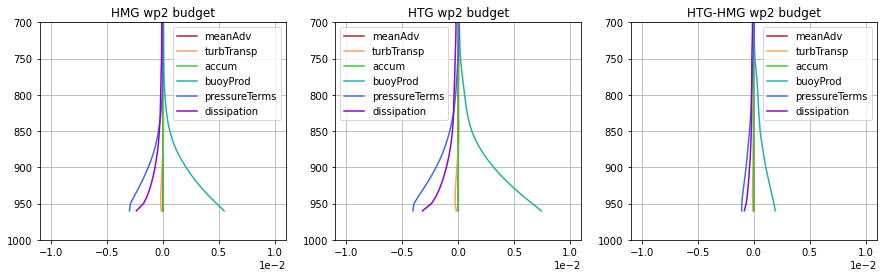

In [45]:
## Real surface:
#   TKE decreases most stronly overnight, from maybe 1a to 8a
startHr = 12
endHr   = 17
wp2_budget_plot(HMGcamDS_localReal_highPct, HTGcamDS_localReal_highPct,
                startHr,endHr,0.011,-0.011,'levInterp')


Means computed over the inclusive period of 12 to 17.


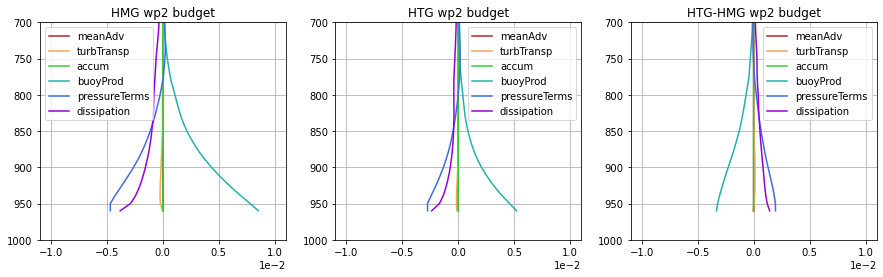

In [46]:
## Real surface:
#   TKE decreases most stronly overnight, from maybe 1a to 8a
startHr = 12
endHr   = 17
wp2_budget_plot(HMGcamDS_localReal_lowPct, HTGcamDS_localReal_lowPct,
                startHr,endHr,0.011,-0.011,'levInterp')


**Say I just want one date though...**

In [11]:
# Select indices of date     
iKeepTimes = np.where((HMGcamDS_localReal['time.year'] ==2015) &
                      (HMGcamDS_localReal['time.month']==6) & 
                      (HMGcamDS_localReal['time.day']  ==10))[0]    

# Now select only those times in the local time array
HMGcamDS_selDay = HMGcamDS_localReal.isel(time=iKeepTimes)
HTGcamDS_selDay = HTGcamDS_localReal.isel(time=iKeepTimes)


Means computed over the inclusive period of 12 to 15.


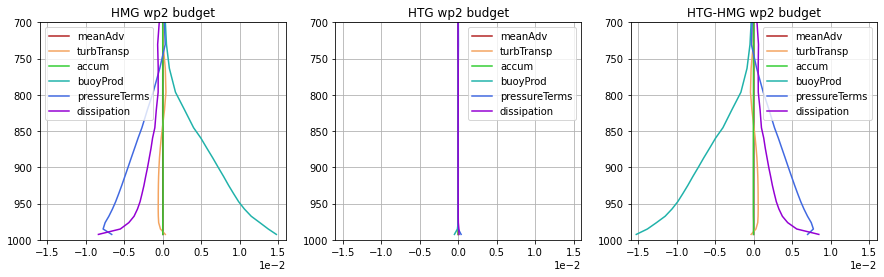

In [12]:
## Real surface:
#   TKE decreases most stronly overnight, from maybe 1a to 8a
startHr = 12
endHr   = 15
wp2_budget_plot(HMGcamDS_selDay, HTGcamDS_selDay,
                startHr,endHr,0.016,-0.016)


(-0.05, 2.5)

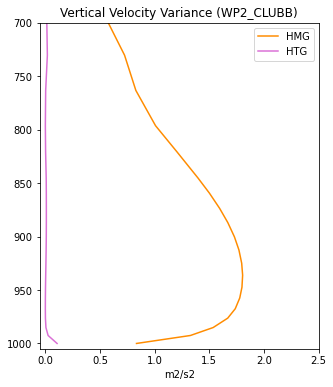

In [13]:
## Plot a few raw variables? 
iTimeSel_dDryHMG = np.where((HMGcamDS_selDay["time.hour"].values>=startHr) & 
                            (HMGcamDS_selDay["time.hour"].values<=endHr))[0]
iTimeSel_dDryHTG = np.where((HTGcamDS_selDay["time.hour"].values>=startHr) & 
                            (HTGcamDS_selDay["time.hour"].values<=endHr))[0]

hourlyMean_TimeSel_HMG = HMGcamDS_selDay.isel(time=iTimeSel_dDryHMG).mean(dim='time')
hourlyMean_TimeSel_HTG = HTGcamDS_selDay.isel(time=iTimeSel_dDryHTG).mean(dim='time')

fig,axs = plt.subplots(1,1, figsize=(5,6))

plotVar = 'WP2_CLUBB'

axs.plot(np.squeeze(hourlyMean_TimeSel_HMG[plotVar].values), hourlyMean_TimeSel_HMG.ilev.values,
        color='darkorange')
axs.plot(np.squeeze(hourlyMean_TimeSel_HTG[plotVar].values), hourlyMean_TimeSel_HTG.ilev.values,
        color='orchid')

axs.legend(['HMG','HTG'])

axs.set_xlabel(HMGcamDS_selDay[plotVar].units)
axs.set_title(HMGcamDS_selDay[plotVar].long_name+' ('+plotVar+')')

axs.invert_yaxis()
axs.set_ylim([1005,700])
axs.set_xlim([-0.05, 2.5])

## WPTHLP budget

In [47]:
## Plot budget terms 

def wpthlp_budget_plot(HMGds,HTGds,startHr,endHr,xmax,xmin,levName):
    
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((HMGds["time.hour"].values>=startHr) & 
                                (HMGds["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((HTGds["time.hour"].values>=startHr) & 
                                (HTGds["time.hour"].values<=endHr))[0]


    hourlyMean_dDryTimeSel_HMG = HMGds.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = HTGds.isel(time=iTimeSel_dDryHTG).mean(dim='time')


    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))

    if levName=='ilev':
        meanAdvHMG        = hourlyMean_dDryTimeSel_HMG['wpthlp_ma'].values[:,0,0]
        turbTranspHMG     = hourlyMean_dDryTimeSel_HMG['wpthlp_ta'].values[:,0,0]
        turbProdHMG       = hourlyMean_dDryTimeSel_HMG['wpthlp_tp'].values[:,0,0]
        accumHMG          = hourlyMean_dDryTimeSel_HMG['wpthlp_ac'].values[:,0,0]
        buoyProdHMG       = hourlyMean_dDryTimeSel_HMG['wpthlp_bp'].values[:,0,0]
        press1HMG         = hourlyMean_dDryTimeSel_HMG['wpthlp_pr1'].values[:,0,0]
        press2HMG         = hourlyMean_dDryTimeSel_HMG['wpthlp_pr2'].values[:,0,0]
        press3HMG         = hourlyMean_dDryTimeSel_HMG['wpthlp_pr3'].values[:,0,0]
        pressureApproxHMG = press1HMG+press2HMG+press3HMG
        dissipationHMG    = hourlyMean_dDryTimeSel_HMG['wpthlp_dp1'].values[:,0,0]

        meanAdvHTG        = hourlyMean_dDryTimeSel_HTG['wpthlp_ma'].values[:,0,0]
        turbTranspHTG     = hourlyMean_dDryTimeSel_HTG['wpthlp_ta'].values[:,0,0]
        turbProdHTG       = hourlyMean_dDryTimeSel_HTG['wpthlp_tp'].values[:,0,0]
        accumHTG          = hourlyMean_dDryTimeSel_HTG['wpthlp_ac'].values[:,0,0]
        buoyProdHTG       = hourlyMean_dDryTimeSel_HTG['wpthlp_bp'].values[:,0,0]
        press1HTG         = hourlyMean_dDryTimeSel_HTG['wpthlp_pr1'].values[:,0,0]
        press2HTG         = hourlyMean_dDryTimeSel_HTG['wpthlp_pr2'].values[:,0,0]
        press3HTG         = hourlyMean_dDryTimeSel_HTG['wpthlp_pr3'].values[:,0,0]
        pressureApproxHTG = press1HTG+press2HTG+press3HTG
        dissipationHTG    = hourlyMean_dDryTimeSel_HTG['wpthlp_dp1'].values[:,0,0]
    elif levName=='levInterp':
        meanAdvHMG        = hourlyMean_dDryTimeSel_HMG['wpthlp_ma_interp'].values[:,0,0]
        turbTranspHMG     = hourlyMean_dDryTimeSel_HMG['wpthlp_ta_interp'].values[:,0,0]
        turbProdHMG       = hourlyMean_dDryTimeSel_HMG['wpthlp_tp_interp'].values[:,0,0]
        accumHMG          = hourlyMean_dDryTimeSel_HMG['wpthlp_ac_interp'].values[:,0,0]
        buoyProdHMG       = hourlyMean_dDryTimeSel_HMG['wpthlp_bp_interp'].values[:,0,0]
        press1HMG         = hourlyMean_dDryTimeSel_HMG['wpthlp_pr1_interp'].values[:,0,0]
        press2HMG         = hourlyMean_dDryTimeSel_HMG['wpthlp_pr2_interp'].values[:,0,0]
        press3HMG         = hourlyMean_dDryTimeSel_HMG['wpthlp_pr3_interp'].values[:,0,0]
        pressureApproxHMG = press1HMG+press2HMG+press3HMG
        dissipationHMG    = hourlyMean_dDryTimeSel_HMG['wpthlp_dp1_interp'].values[:,0,0]

        meanAdvHTG        = hourlyMean_dDryTimeSel_HTG['wpthlp_ma_interp'].values[:,0,0]
        turbTranspHTG     = hourlyMean_dDryTimeSel_HTG['wpthlp_ta_interp'].values[:,0,0]
        turbProdHTG       = hourlyMean_dDryTimeSel_HTG['wpthlp_tp_interp'].values[:,0,0]
        accumHTG          = hourlyMean_dDryTimeSel_HTG['wpthlp_ac_interp'].values[:,0,0]
        buoyProdHTG       = hourlyMean_dDryTimeSel_HTG['wpthlp_bp_interp'].values[:,0,0]
        press1HTG         = hourlyMean_dDryTimeSel_HTG['wpthlp_pr1_interp'].values[:,0,0]
        press2HTG         = hourlyMean_dDryTimeSel_HTG['wpthlp_pr2_interp'].values[:,0,0]
        press3HTG         = hourlyMean_dDryTimeSel_HTG['wpthlp_pr3_interp'].values[:,0,0]
        pressureApproxHTG = press1HTG+press2HTG+press3HTG
        dissipationHTG    = hourlyMean_dDryTimeSel_HTG['wpthlp_dp1_interp'].values[:,0,0]
    
    fig,axs = plt.subplots(1,3, figsize=(15,4))
    axs = axs.ravel()

    colorsList = np.asarray(['firebrick','sandybrown','olivedrab','limegreen','lightseagreen','royalblue','darkviolet'])

    axs[0].plot(meanAdvHMG[0:-1],        HMGds[levName].values[0:-1], color=colorsList[0], label='meanAdv')
    axs[0].plot(turbTranspHMG[0:-1],     HMGds[levName].values[0:-1], color=colorsList[1], label='turbTransp')
    axs[0].plot(turbProdHMG[0:-1],       HMGds[levName].values[0:-1], color=colorsList[2], label='turbProd')
    axs[0].plot(accumHMG[0:-1],          HMGds[levName].values[0:-1], color=colorsList[3], label='accum')
    axs[0].plot(buoyProdHMG[0:-1],       HMGds[levName].values[0:-1], color=colorsList[4], label='buoyProd')
    axs[0].plot(pressureApproxHMG[0:-1], HMGds[levName].values[0:-1], color=colorsList[5], label='pressureTerms')
    axs[0].plot(dissipationHMG[0:-1],    HMGds[levName].values[0:-1], color=colorsList[6], label='dissipation')
    # axs[0].plot(residualHMG[0:-1],       HMGcamDS_local[levName].values[0:-1],'ko-', label='residual')

    axs[1].plot(meanAdvHTG[0:-1],        HTGds[levName].values[0:-1], color=colorsList[0], label='meanAdv')
    axs[1].plot(turbTranspHTG[0:-1],     HTGds[levName].values[0:-1], color=colorsList[1], label='turbTransp')
    axs[1].plot(turbProdHTG[0:-1],       HTGds[levName].values[0:-1], color=colorsList[2], label='turbProd')
    axs[1].plot(accumHTG[0:-1],          HTGds[levName].values[0:-1], color=colorsList[3], label='accum')
    axs[1].plot(buoyProdHTG[0:-1],       HTGds[levName].values[0:-1], color=colorsList[4], label='buoyProd')
    axs[1].plot(pressureApproxHTG[0:-1], HTGds[levName].values[0:-1], color=colorsList[5], label='pressureTerms')
    axs[1].plot(dissipationHTG[0:-1],    HTGds[levName].values[0:-1], color=colorsList[6], label='dissipation')
    # axs[0].plot(residualHMG[0:-1],       HMGcamDS_local.ilev.values[0:-1],'ko-', label='residual')


    # Plot difference
    axs[2].plot(meanAdvHTG[0:-1]-meanAdvHMG[0:-1],              HTGds[levName].values[0:-1], color=colorsList[0], label='meanAdv')
    axs[2].plot(turbTranspHTG[0:-1]-turbTranspHMG[0:-1],        HTGds[levName].values[0:-1], color=colorsList[1], label='turbTransp')
    axs[2].plot(turbProdHTG[0:-1]-turbProdHMG[0:-1],            HTGds[levName].values[0:-1], color=colorsList[2], label='turbProd')
    axs[2].plot(accumHTG[0:-1]-accumHMG[0:-1],                  HTGds[levName].values[0:-1], color=colorsList[3], label='accum')
    axs[2].plot(buoyProdHTG[0:-1]-buoyProdHMG[0:-1],            HTGds[levName].values[0:-1], color=colorsList[4], label='buoyProd')
    axs[2].plot(pressureApproxHTG[0:-1]-pressureApproxHMG[0:-1], HTGds[levName].values[0:-1], color=colorsList[5], label='pressureTerms')
    axs[2].plot(dissipationHTG[0:-1]-dissipationHMG[0:-1],      HTGds[levName].values[0:-1], color=colorsList[6], label='dissipation')
    
    # Consistent settings across subplots 
    axs[0].set_ylim([700,1000])
    axs[0].set_xlim([xmin,xmax])
    axs[0].invert_yaxis()
    axs[0].legend()
    axs[0].set_title('HMG wpthlp budget')

    axs[1].set_ylim([700,1000])
    axs[1].set_xlim([xmin,xmax])
    axs[1].invert_yaxis()
    axs[1].legend()
    axs[1].set_title('HTG wpthlp budget')

    axs[2].set_ylim([700,1000])
    axs[2].set_xlim([xmin,xmax])
    axs[2].invert_yaxis()
    axs[2].legend()
    axs[2].set_title('HTG-HMG wpthlp budget')
    
    axs[0].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[1].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[2].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    
    axs[0].grid()
    axs[1].grid()
    axs[2].grid()
    
    return



Means computed over the inclusive period of 12 to 17.


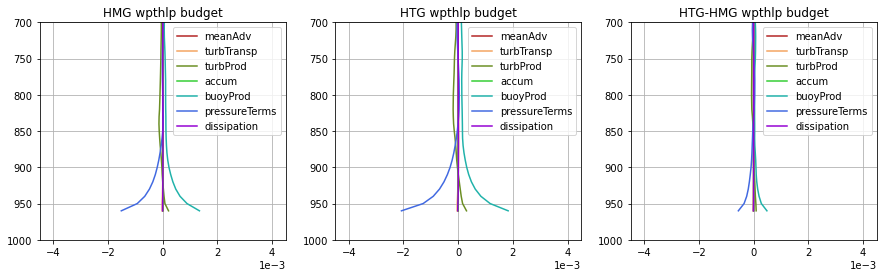

In [49]:
## Real surface:
#   TKE decreases most stronly overnight, from maybe 1a to 8a
startHr = 12
endHr   = 17
wpthlp_budget_plot(HMGcamDS_localReal_highPct, HTGcamDS_localReal_highPct,
                startHr,endHr,0.0045,-0.0045,'levInterp')


Means computed over the inclusive period of 12 to 17.


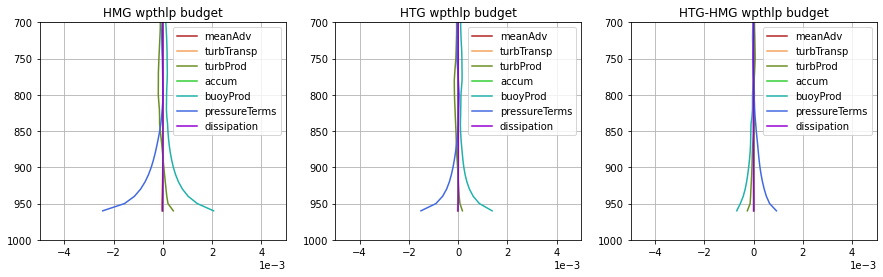

In [50]:
## Real surface:
#   TKE decreases most stronly overnight, from maybe 1a to 8a
startHr = 12
endHr   = 17
wpthlp_budget_plot(HMGcamDS_localReal_lowPct, HTGcamDS_localReal_lowPct,
                startHr,endHr,0.005,-0.005,'levInterp')


In [30]:
## Plot budget terms 

def wpthlp_budget_plotPressureTerms(HMGds,HTGds,startHr,endHr,xmax,xmin):
    
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((HMGds["time.hour"].values>=startHr) & 
                                (HMGds["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((HTGds["time.hour"].values>=startHr) & 
                                (HTGds["time.hour"].values<=endHr))[0]


    hourlyMean_dDryTimeSel_HMG = HMGds.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = HTGds.isel(time=iTimeSel_dDryHTG).mean(dim='time')


    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))


    meanAdvHMG        = hourlyMean_dDryTimeSel_HMG['wpthlp_ma'].values[:,0,0]
    turbTranspHMG     = hourlyMean_dDryTimeSel_HMG['wpthlp_ta'].values[:,0,0]
    turbProdHMG       = hourlyMean_dDryTimeSel_HMG['wpthlp_tp'].values[:,0,0]
    accumHMG          = hourlyMean_dDryTimeSel_HMG['wpthlp_ac'].values[:,0,0]
    buoyProdHMG       = hourlyMean_dDryTimeSel_HMG['wpthlp_bp'].values[:,0,0]
    press1HMG         = hourlyMean_dDryTimeSel_HMG['wpthlp_pr1'].values[:,0,0]
    press2HMG         = hourlyMean_dDryTimeSel_HMG['wpthlp_pr2'].values[:,0,0]
    press3HMG         = hourlyMean_dDryTimeSel_HMG['wpthlp_pr3'].values[:,0,0]
    pressureApproxHMG = press1HMG+press2HMG+press3HMG
    dissipationHMG    = hourlyMean_dDryTimeSel_HMG['wpthlp_dp1'].values[:,0,0]

    meanAdvHTG        = hourlyMean_dDryTimeSel_HTG['wpthlp_ma'].values[:,0,0]
    turbTranspHTG     = hourlyMean_dDryTimeSel_HTG['wpthlp_ta'].values[:,0,0]
    turbProdHTG       = hourlyMean_dDryTimeSel_HTG['wpthlp_tp'].values[:,0,0]
    accumHTG          = hourlyMean_dDryTimeSel_HTG['wpthlp_ac'].values[:,0,0]
    buoyProdHTG       = hourlyMean_dDryTimeSel_HTG['wpthlp_bp'].values[:,0,0]
    press1HTG         = hourlyMean_dDryTimeSel_HTG['wpthlp_pr1'].values[:,0,0]
    press2HTG         = hourlyMean_dDryTimeSel_HTG['wpthlp_pr2'].values[:,0,0]
    press3HTG         = hourlyMean_dDryTimeSel_HTG['wpthlp_pr3'].values[:,0,0]
    pressureApproxHTG = press1HTG+press2HTG+press3HTG
    dissipationHTG    = hourlyMean_dDryTimeSel_HTG['wpthlp_dp1'].values[:,0,0]
    
    fig,axs = plt.subplots(1,3, figsize=(15,4))
    axs = axs.ravel()

#     colorsList = np.asarray(['firebrick','sandybrown','olivedrab','limegreen','lightseagreen','royalblue','darkviolet'])
    colorsList = np.asarray(['yellowgreen','lightseagreen','crimson'])

    axs[0].plot(press1HMG[0:-1],        HMGds.ilev.values[0:-1], color=colorsList[0], label='PressureTerm1')
    axs[0].plot(press2HMG[0:-1],        HMGds.ilev.values[0:-1], color=colorsList[1], label='PressureTerm2')
    axs[0].plot(press3HMG[0:-1],        HMGds.ilev.values[0:-1], color=colorsList[2], label='PressureTerm3')
    # axs[0].plot(residualHMG[0:-1],       HMGcamDS_local.ilev.values[0:-1],'ko-', label='residual')

    axs[1].plot(press1HTG[0:-1],        HMGds.ilev.values[0:-1], color=colorsList[0], label='PressureTerm1')
    axs[1].plot(press2HTG[0:-1],        HMGds.ilev.values[0:-1], color=colorsList[1], label='PressureTerm2')
    axs[1].plot(press3HTG[0:-1],        HMGds.ilev.values[0:-1], color=colorsList[2], label='PressureTerm3')
    # axs[0].plot(residualHMG[0:-1],       HMGcamDS_local.ilev.values[0:-1],'ko-', label='residual')


    # Plot difference
    axs[2].plot(press1HTG[0:-1]-press1HMG[0:-1],              HTGds.ilev.values[0:-1], color=colorsList[0], label='PresureTerm1')
    axs[2].plot(press2HTG[0:-1]-press2HMG[0:-1],              HTGds.ilev.values[0:-1], color=colorsList[1], label='PresureTerm2')
    axs[2].plot(press3HTG[0:-1]-press3HMG[0:-1],              HTGds.ilev.values[0:-1], color=colorsList[2], label='PresureTerm3')

    
    # Consistent settings across subplots 
    axs[0].set_ylim([700,1000])
    axs[0].set_xlim([xmin,xmax])
    axs[0].invert_yaxis()
    axs[0].legend()
    axs[0].set_title('HMG wpthlp budget')

    axs[1].set_ylim([700,1000])
    axs[1].set_xlim([xmin,xmax])
    axs[1].invert_yaxis()
    axs[1].legend()
    axs[1].set_title('HTG wpthlp budget')

    axs[2].set_ylim([700,1000])
    axs[2].set_xlim([xmin,xmax])
    axs[2].invert_yaxis()
    axs[2].legend()
    axs[2].set_title('HTG-HMG wpthlp budget')
    
    axs[0].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[1].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[2].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    
    axs[0].grid()
    axs[1].grid()
    axs[2].grid()
    
    return



Means computed over the inclusive period of 12 to 17.


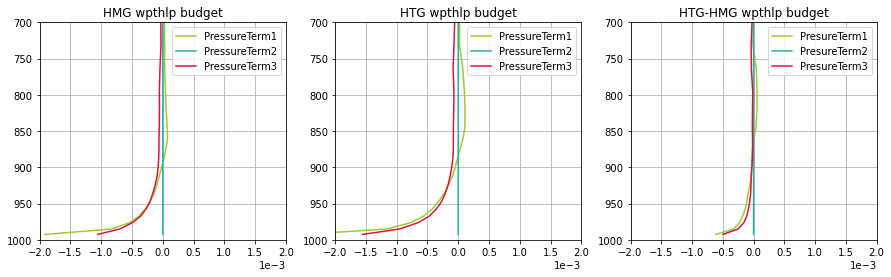

In [34]:
## Real surface:
#   TKE decreases most stronly overnight, from maybe 1a to 8a
startHr = 12
endHr   = 17
wpthlp_budget_plotPressureTerms(HMGcamDS_localReal_highPct, HTGcamDS_localReal_highPct,
                startHr,endHr,0.002,-0.002)


Means computed over the inclusive period of 12 to 17.


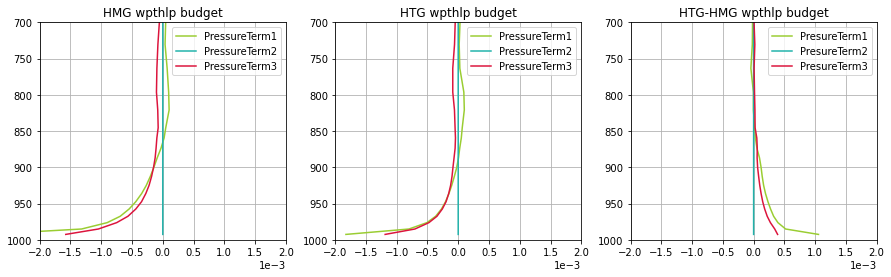

In [35]:
## Real surface:
#   TKE decreases most stronly overnight, from maybe 1a to 8a
startHr = 12
endHr   = 17
wpthlp_budget_plotPressureTerms(HMGcamDS_localReal_lowPct, HTGcamDS_localReal_lowPct,
                startHr,endHr,0.002,-0.002)


In [22]:
# Select indices of date     
iKeepTimes = np.where((HMGcamDS_localReal['time.year'] ==2015) &
                      (HMGcamDS_localReal['time.month']==6) & 
                      (HMGcamDS_localReal['time.day']  ==10))[0]    

# Now select only those times in the local time array
HMGcamDS_selDay = HMGcamDS_localReal.isel(time=iKeepTimes)
HTGcamDS_selDay = HTGcamDS_localReal.isel(time=iKeepTimes)



Means computed over the inclusive period of 12 to 15.


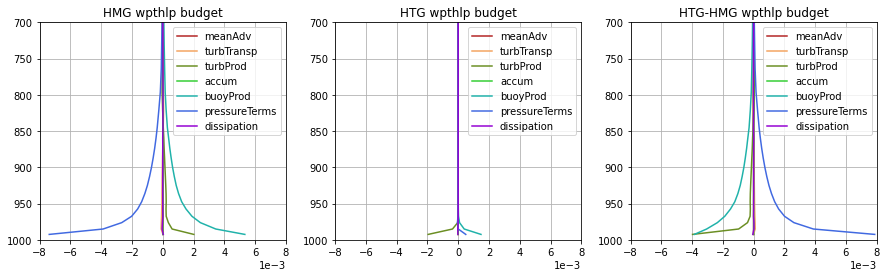

In [23]:
## Real surface:
#   TKE decreases most stronly overnight, from maybe 1a to 8a
startHr = 12
endHr   = 15
wpthlp_budget_plot(HMGcamDS_selDay, HTGcamDS_selDay,
                startHr,endHr,0.008,-0.008)


## WPRTP budget

In [51]:
## Plot budget terms 

def wprtp_budget_plot(HMGds,HTGds,startHr,endHr,xmax,xmin,levName):
    
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((HMGds["time.hour"].values>=startHr) & 
                                (HMGds["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((HTGds["time.hour"].values>=startHr) & 
                                (HTGds["time.hour"].values<=endHr))[0]


    hourlyMean_dDryTimeSel_HMG = HMGds.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = HTGds.isel(time=iTimeSel_dDryHTG).mean(dim='time')


    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))

    if levName=='ilev':
        meanAdvHMG        = hourlyMean_dDryTimeSel_HMG['wprtp_ma'].values[:,0,0]
        turbTranspHMG     = hourlyMean_dDryTimeSel_HMG['wprtp_ta'].values[:,0,0]
        turbProdHMG       = hourlyMean_dDryTimeSel_HMG['wprtp_tp'].values[:,0,0]
        accumHMG          = hourlyMean_dDryTimeSel_HMG['wprtp_ac'].values[:,0,0]
        buoyProdHMG       = hourlyMean_dDryTimeSel_HMG['wprtp_bp'].values[:,0,0]
        press1HMG         = hourlyMean_dDryTimeSel_HMG['wprtp_pr1'].values[:,0,0]
        press2HMG         = hourlyMean_dDryTimeSel_HMG['wprtp_pr2'].values[:,0,0]
        press3HMG         = hourlyMean_dDryTimeSel_HMG['wprtp_pr3'].values[:,0,0]
        pressureApproxHMG = press1HMG+press2HMG+press3HMG
        dissipationHMG    = hourlyMean_dDryTimeSel_HMG['wprtp_dp1'].values[:,0,0]

        meanAdvHTG        = hourlyMean_dDryTimeSel_HTG['wprtp_ma'].values[:,0,0]
        turbTranspHTG     = hourlyMean_dDryTimeSel_HTG['wprtp_ta'].values[:,0,0]
        turbProdHTG       = hourlyMean_dDryTimeSel_HTG['wprtp_tp'].values[:,0,0]
        accumHTG          = hourlyMean_dDryTimeSel_HTG['wprtp_ac'].values[:,0,0]
        buoyProdHTG       = hourlyMean_dDryTimeSel_HTG['wprtp_bp'].values[:,0,0]
        press1HTG         = hourlyMean_dDryTimeSel_HTG['wprtp_pr1'].values[:,0,0]
        press2HTG         = hourlyMean_dDryTimeSel_HTG['wprtp_pr2'].values[:,0,0]
        press3HTG         = hourlyMean_dDryTimeSel_HTG['wprtp_pr3'].values[:,0,0]
        pressureApproxHTG = press1HTG+press2HTG+press3HTG
        dissipationHTG    = hourlyMean_dDryTimeSel_HTG['wprtp_dp1'].values[:,0,0]
    elif levName=='levInterp':
        meanAdvHMG        = hourlyMean_dDryTimeSel_HMG['wprtp_ma_interp'].values[:,0,0]
        turbTranspHMG     = hourlyMean_dDryTimeSel_HMG['wprtp_ta_interp'].values[:,0,0]
        turbProdHMG       = hourlyMean_dDryTimeSel_HMG['wprtp_tp_interp'].values[:,0,0]
        accumHMG          = hourlyMean_dDryTimeSel_HMG['wprtp_ac_interp'].values[:,0,0]
        buoyProdHMG       = hourlyMean_dDryTimeSel_HMG['wprtp_bp_interp'].values[:,0,0]
        press1HMG         = hourlyMean_dDryTimeSel_HMG['wprtp_pr1_interp'].values[:,0,0]
        press2HMG         = hourlyMean_dDryTimeSel_HMG['wprtp_pr2_interp'].values[:,0,0]
        press3HMG         = hourlyMean_dDryTimeSel_HMG['wprtp_pr3_interp'].values[:,0,0]
        pressureApproxHMG = press1HMG+press2HMG+press3HMG
        dissipationHMG    = hourlyMean_dDryTimeSel_HMG['wprtp_dp1_interp'].values[:,0,0]

        meanAdvHTG        = hourlyMean_dDryTimeSel_HTG['wprtp_ma_interp'].values[:,0,0]
        turbTranspHTG     = hourlyMean_dDryTimeSel_HTG['wprtp_ta_interp'].values[:,0,0]
        turbProdHTG       = hourlyMean_dDryTimeSel_HTG['wprtp_tp_interp'].values[:,0,0]
        accumHTG          = hourlyMean_dDryTimeSel_HTG['wprtp_ac_interp'].values[:,0,0]
        buoyProdHTG       = hourlyMean_dDryTimeSel_HTG['wprtp_bp_interp'].values[:,0,0]
        press1HTG         = hourlyMean_dDryTimeSel_HTG['wprtp_pr1_interp'].values[:,0,0]
        press2HTG         = hourlyMean_dDryTimeSel_HTG['wprtp_pr2_interp'].values[:,0,0]
        press3HTG         = hourlyMean_dDryTimeSel_HTG['wprtp_pr3_interp'].values[:,0,0]
        pressureApproxHTG = press1HTG+press2HTG+press3HTG
        dissipationHTG    = hourlyMean_dDryTimeSel_HTG['wprtp_dp1_interp'].values[:,0,0]
    
    fig,axs = plt.subplots(1,3, figsize=(15,4))
    axs = axs.ravel()

    colorsList = np.asarray(['firebrick','sandybrown','olivedrab','limegreen','lightseagreen','royalblue','darkviolet'])

    axs[0].plot(meanAdvHMG[0:-1],        HMGds[levName].values[0:-1], color=colorsList[0], label='meanAdv')
    axs[0].plot(turbTranspHMG[0:-1],     HMGds[levName].values[0:-1], color=colorsList[1], label='turbTransp')
    axs[0].plot(turbProdHMG[0:-1],       HMGds[levName].values[0:-1], color=colorsList[2], label='turbProd')
    axs[0].plot(accumHMG[0:-1],          HMGds[levName].values[0:-1], color=colorsList[3], label='accum')
    axs[0].plot(buoyProdHMG[0:-1],       HMGds[levName].values[0:-1], color=colorsList[4], label='buoyProd')
    axs[0].plot(pressureApproxHMG[0:-1], HMGds[levName].values[0:-1], color=colorsList[5], label='pressureTerms')
    axs[0].plot(dissipationHMG[0:-1],    HMGds[levName].values[0:-1], color=colorsList[6], label='dissipation')
    # axs[0].plot(residualHMG[0:-1],       HMGcamDS_local.ilev.values[0:-1],'ko-', label='residual')

    axs[1].plot(meanAdvHTG[0:-1],        HTGds[levName].values[0:-1], color=colorsList[0], label='meanAdv')
    axs[1].plot(turbTranspHTG[0:-1],     HTGds[levName].values[0:-1], color=colorsList[1], label='turbTransp')
    axs[1].plot(turbProdHTG[0:-1],       HTGds[levName].values[0:-1], color=colorsList[2], label='turbProd')
    axs[1].plot(accumHTG[0:-1],          HTGds[levName].values[0:-1], color=colorsList[3], label='accum')
    axs[1].plot(buoyProdHTG[0:-1],       HTGds[levName].values[0:-1], color=colorsList[4], label='buoyProd')
    axs[1].plot(pressureApproxHTG[0:-1], HTGds[levName].values[0:-1], color=colorsList[5], label='pressureTerms')
    axs[1].plot(dissipationHTG[0:-1],    HTGds[levName].values[0:-1], color=colorsList[6], label='dissipation')
    # axs[0].plot(residualHMG[0:-1],       HMGcamDS_local.ilev.values[0:-1],'ko-', label='residual')


    # Plot difference
    axs[2].plot(meanAdvHTG[0:-1]-meanAdvHMG[0:-1],              HTGds[levName].values[0:-1], color=colorsList[0], label='meanAdv')
    axs[2].plot(turbTranspHTG[0:-1]-turbTranspHMG[0:-1],        HTGds[levName].values[0:-1], color=colorsList[1], label='turbTransp')
    axs[2].plot(turbProdHTG[0:-1]-turbProdHMG[0:-1],            HTGds[levName].values[0:-1], color=colorsList[2], label='turbProd')
    axs[2].plot(accumHTG[0:-1]-accumHMG[0:-1],                  HTGds[levName].values[0:-1], color=colorsList[3], label='accum')
    axs[2].plot(buoyProdHTG[0:-1]-buoyProdHMG[0:-1],            HTGds[levName].values[0:-1], color=colorsList[4], label='buoyProd')
    axs[2].plot(pressureApproxHTG[0:-1]-pressureApproxHMG[0:-1], HTGds[levName].values[0:-1], color=colorsList[5], label='pressureTerms')
    axs[2].plot(dissipationHTG[0:-1]-dissipationHMG[0:-1],      HTGds[levName].values[0:-1], color=colorsList[6], label='dissipation')
    
    # Consistent settings across subplots 
    axs[0].set_ylim([700,1000])
    axs[0].set_xlim([xmin,xmax])
    axs[0].invert_yaxis()
    axs[0].legend()
    axs[0].set_title('HMG wprtp budget')

    axs[1].set_ylim([700,1000])
    axs[1].set_xlim([xmin,xmax])
    axs[1].invert_yaxis()
    axs[1].legend()
    axs[1].set_title('HTG wprtp budget')

    axs[2].set_ylim([700,1000])
    axs[2].set_xlim([xmin,xmax])
    axs[2].invert_yaxis()
    axs[2].legend()
    axs[2].set_title('HTG-HMG wprtp budget')
    
    axs[0].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[1].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[2].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    
    axs[0].grid()
    axs[1].grid()
    axs[2].grid()
    
    return



Means computed over the inclusive period of 12 to 17.


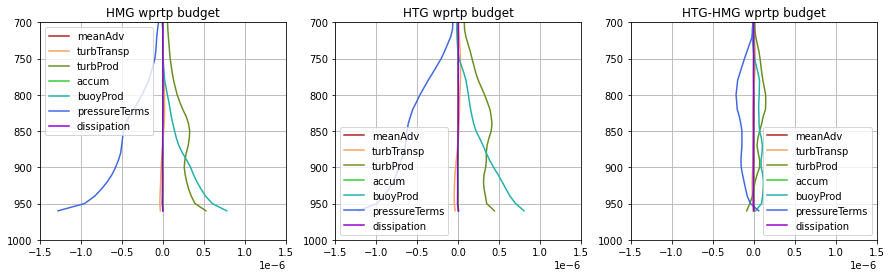

In [60]:
## Real surface:
#   TKE decreases most stronly overnight, from maybe 1a to 8a
startHr = 12
endHr   = 17
wprtp_budget_plot(HMGcamDS_localReal_highPct, HTGcamDS_localReal_highPct,
                startHr,endHr,0.0000015,-0.0000015,'levInterp')


Means computed over the inclusive period of 12 to 17.


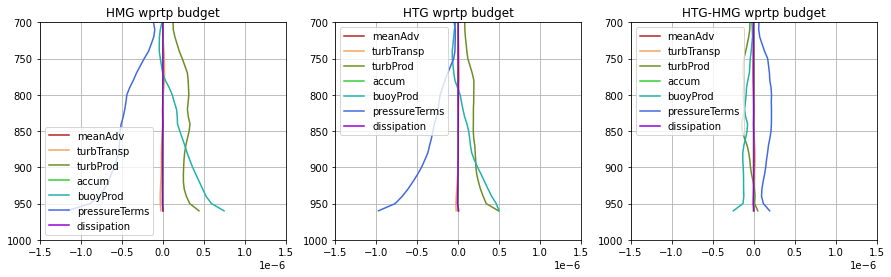

In [61]:
## Real surface:
#   TKE decreases most stronly overnight, from maybe 1a to 8a
startHr = 12
endHr   = 17
wprtp_budget_plot(HMGcamDS_localReal_lowPct, HTGcamDS_localReal_lowPct,
                startHr,endHr,0.0000015,-0.0000015,'levInterp')


## THLP2 Budget

In [38]:
## Plot budget terms 

def thlp2_budget_plot(HMGds,HTGds,startHr,endHr,xmax,xmin,levName):
    
    # ------- dDry days ----------
    iTimeSel_dDryHMG = np.where((HMGds["time.hour"].values>=startHr) & 
                                (HMGds["time.hour"].values<=endHr))[0]
    iTimeSel_dDryHTG = np.where((HTGds["time.hour"].values>=startHr) & 
                                (HTGds["time.hour"].values<=endHr))[0]


    hourlyMean_dDryTimeSel_HMG = HMGds.isel(time=iTimeSel_dDryHMG).mean(dim='time')
    hourlyMean_dDryTimeSel_HTG = HTGds.isel(time=iTimeSel_dDryHTG).mean(dim='time')


    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))

    ## Model levels 
    if levName=='ilev':
        meanAdvHMG        = hourlyMean_dDryTimeSel_HMG['thlp2_ma'].values[:,0,0]
        turbTranspHMG     = hourlyMean_dDryTimeSel_HMG['thlp2_ta'].values[:,0,0]
        turbProdHMG       = hourlyMean_dDryTimeSel_HMG['thlp2_tp'].values[:,0,0]
        dissipation1HMG   = hourlyMean_dDryTimeSel_HMG['thlp2_dp1'].values[:,0,0]
        dissipation2HMG   = hourlyMean_dDryTimeSel_HMG['thlp2_dp2'].values[:,0,0]

        meanAdvHTG        = hourlyMean_dDryTimeSel_HTG['thlp2_ma'].values[:,0,0]
        turbTranspHTG     = hourlyMean_dDryTimeSel_HTG['thlp2_ta'].values[:,0,0]
        turbProdHTG       = hourlyMean_dDryTimeSel_HTG['thlp2_tp'].values[:,0,0]
        dissipation1HTG   = hourlyMean_dDryTimeSel_HTG['thlp2_dp1'].values[:,0,0]
        dissipation2HTG   = hourlyMean_dDryTimeSel_HTG['thlp2_dp2'].values[:,0,0]
    
    ## Interpolated levels
    elif levName == 'levInterp':
        meanAdvHMG        = hourlyMean_dDryTimeSel_HMG['thlp2_ma_interp'].values[:,0,0]
        turbTranspHMG     = hourlyMean_dDryTimeSel_HMG['thlp2_ta_interp'].values[:,0,0]
        turbProdHMG       = hourlyMean_dDryTimeSel_HMG['thlp2_tp_interp'].values[:,0,0]
        dissipation1HMG   = hourlyMean_dDryTimeSel_HMG['thlp2_dp1_interp'].values[:,0,0]
        dissipation2HMG   = hourlyMean_dDryTimeSel_HMG['thlp2_dp2_interp'].values[:,0,0]

        meanAdvHTG        = hourlyMean_dDryTimeSel_HTG['thlp2_ma_interp'].values[:,0,0]
        turbTranspHTG     = hourlyMean_dDryTimeSel_HTG['thlp2_ta_interp'].values[:,0,0]
        turbProdHTG       = hourlyMean_dDryTimeSel_HTG['thlp2_tp_interp'].values[:,0,0]
        dissipation1HTG   = hourlyMean_dDryTimeSel_HTG['thlp2_dp1_interp'].values[:,0,0]
        dissipation2HTG   = hourlyMean_dDryTimeSel_HTG['thlp2_dp2_interp'].values[:,0,0]
    
    fig,axs = plt.subplots(1,3, figsize=(15,4))
    axs = axs.ravel()

    colorsList = np.asarray(['firebrick','sandybrown','olivedrab','limegreen','lightseagreen','royalblue','darkviolet'])

    axs[0].plot(meanAdvHMG[0:-1],        HMGds[levName].values[0:-1], color=colorsList[0], label='meanAdv')
    axs[0].plot(turbTranspHMG[0:-1],     HMGds[levName].values[0:-1], color=colorsList[1], label='turbTransp')
    axs[0].plot(turbProdHMG[0:-1],       HMGds[levName].values[0:-1], color=colorsList[2], label='turbProd')
    axs[0].plot(dissipation1HMG[0:-1],   HMGds[levName].values[0:-1], color=colorsList[3], label='dissipation1')
    axs[0].plot(dissipation2HMG[0:-1],   HMGds[levName].values[0:-1], color=colorsList[4], label='dissipation2')


    axs[1].plot(meanAdvHTG[0:-1],        HTGds[levName].values[0:-1], color=colorsList[0], label='meanAdv')
    axs[1].plot(turbTranspHTG[0:-1],     HTGds[levName].values[0:-1], color=colorsList[1], label='turbTransp')
    axs[1].plot(turbProdHTG[0:-1],       HTGds[levName].values[0:-1], color=colorsList[2], label='turbProd')
    axs[1].plot(dissipation1HTG[0:-1],   HTGds[levName].values[0:-1], color=colorsList[3], label='dissipation1')
    axs[1].plot(dissipation2HTG[0:-1],   HTGds[levName].values[0:-1], color=colorsList[4], label='dissipation2')

    # Plot difference
    axs[2].plot(meanAdvHTG[0:-1]-meanAdvHMG[0:-1],              HTGds[levName].values[0:-1], color=colorsList[0], label='meanAdv')
    axs[2].plot(turbTranspHTG[0:-1]-turbTranspHMG[0:-1],        HTGds[levName].values[0:-1], color=colorsList[1], label='turbTransp')
    axs[2].plot(turbProdHTG[0:-1]-turbProdHMG[0:-1],            HTGds[levName].values[0:-1], color=colorsList[2], label='turbProd')
    axs[2].plot(dissipation1HTG[0:-1]-dissipation1HMG[0:-1],    HTGds[levName].values[0:-1], color=colorsList[3], label='dissipation1')
    axs[2].plot(dissipation2HTG[0:-1]-dissipation2HMG[0:-1],    HTGds[levName].values[0:-1], color=colorsList[4], label='dissipation2')

    # Consistent settings across subplots 
    axs[0].set_ylim([800,1000])
    axs[0].set_xlim([xmin,xmax])
    axs[0].invert_yaxis()
    axs[0].legend()
    axs[0].set_title('HMG thlp2 budget')

    axs[1].set_ylim([800,1000])
    axs[1].set_xlim([xmin,xmax])
    axs[1].invert_yaxis()
    axs[1].legend()
    axs[1].set_title('HTG thlp2 budget')

    axs[2].set_ylim([800,1000])
    axs[2].set_xlim([xmin,xmax])
    axs[2].invert_yaxis()
    axs[2].legend()
    axs[2].set_title('HTG-HMG thlp2 budget')
    
    axs[0].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[1].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[2].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    
    axs[0].grid()
    axs[1].grid()
    axs[2].grid()
    
    return


Means computed over the inclusive period of 12 to 17.


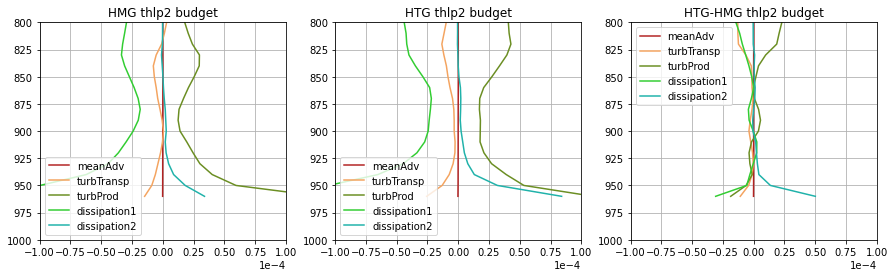

In [39]:
## Real surface:
#   TKE decreases most stronly overnight, from maybe 1a to 8a
startHr = 12
endHr   = 17
thlp2_budget_plot(HMGcamDS_localReal_highPct, HTGcamDS_localReal_highPct,
                 startHr,endHr,0.0001,-0.0001,
                 'levInterp')


Means computed over the inclusive period of 12 to 17.


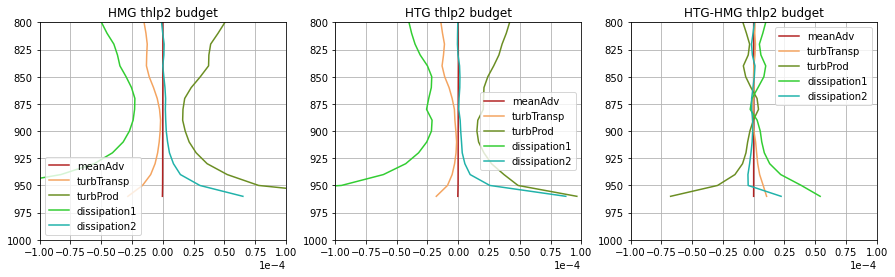

In [40]:
## Real surface:
#   TKE decreases most stronly overnight, from maybe 1a to 8a
startHr = 12
endHr   = 17
thlp2_budget_plot(HMGcamDS_localReal_lowPct, HTGcamDS_localReal_lowPct,
                 startHr,endHr,0.0001,-0.0001,
                 'levInterp')
